**Import libraries**

In [1]:
!pip install 'keras<3.0.0' mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 38.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
!pip install vit-keras

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=39c4061a03352d527f53e69f40935045ecbbb2610f21c1086084d28118f9b0c7
  Stored in directory: /root/.cache/pip/wheels/3d/7c/f1/f87f51d07a2513aa0fb128d5eb504da1fcef9c87475d9eef64
Successfully built validators


In [3]:
!pip install tensorflow-addon

ERROR: Could not find a version that satisfies the requirement tensorflow-addon (from versions: none)
ERROR: No matching distribution found for tensorflow-addon


In [4]:
# Data processing
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageEnhance
import cv2

# Models
from vit_keras import vit
import tensorflow_addons as tfa
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from torch.optim import adamw
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
from itertools import combinations

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import warnings
import random
from numpy.random import seed
import gc

In [6]:
warnings.filterwarnings('ignore', module='vit_keras')

In [7]:
# Set random seed in Numpy
np.random.seed(24)

# Set random seed in Tensorflow
tf.random.set_seed(24) 

# 1. Load data

In [8]:
# Data directory Colab
#data_dir ='/content/drive/MyDrive/Colab Notebooks/brain-tumor-mri-dataset'

# Data directory Kaggle
data_dir = '/kaggle/input/brain-tumor-mri-dataset'

# Create labels
labels = []

for sub_folder in os.listdir(os.path.join(data_dir,'Training')):
    labels.append(sub_folder)
print(labels)

['pituitary', 'notumor', 'meningioma', 'glioma']


In [9]:
# Load and combine data from Training and Testing folder
X_train = []
y_train = []
img_size = 224

def read_data(subset):
  for i in labels:
      folderPath = os.path.join(data_dir,subset,i)
      for j in tqdm(os.listdir(folderPath)):
          img = cv2.imread(os.path.join(folderPath,j))
          img = cv2.resize(img,(img_size, img_size))
          X_train.append(img)
          y_train.append(i)

read_data('Training')
read_data('Testing')
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:02<00:00, 104.82it/s]


### Sample image from each of the four classes

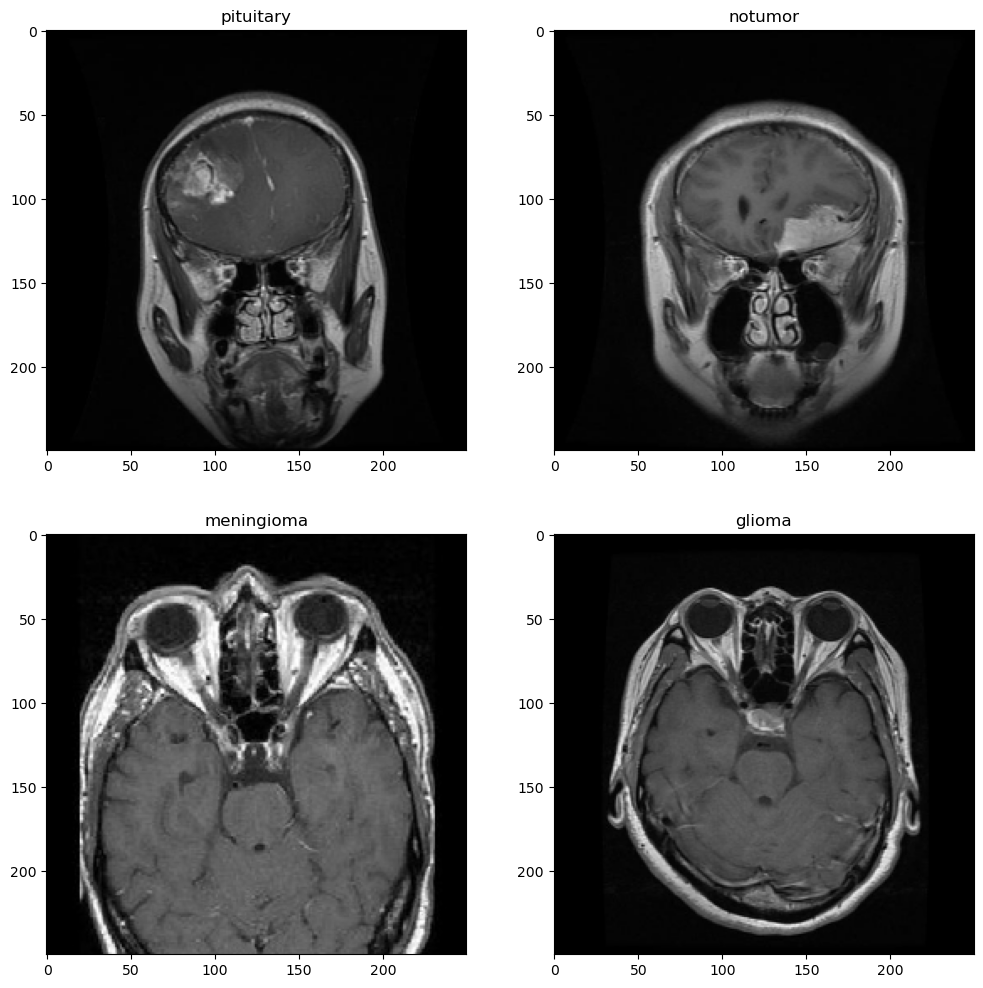

In [10]:
# Plot sample from each class
plt.figure(figsize=(12, 12))

samples_path = ['Training/glioma/Tr-glTr_0000.jpg', 
                'Training/meningioma/Tr-meTr_0000.jpg', 
                'Training/notumor/Tr-noTr_0000.jpg',
                'Training/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(os.path.join(data_dir,samples_path[i]))
    if img is None:
        print('Wrong path')
    else:
      img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.title(labels[i])

plt.savefig('sample-image-each-class.png', bbox_inches = 'tight')

# 3. Data preprocessing

In [11]:
print(np.min(X_train))
print(np.max(X_train))

0
255


In [12]:
X_train = vit.preprocess_inputs(X_train)
print(np.min(X_train))
print(np.max(X_train))

-1.0
1.0


### Create data split
The size of the training-, validation,- and test set are 76,5%, 13,5%, 10% of the total samples, respectively

In [13]:
# Shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=24)

# Create small subset of the dataset for testing purposes
X_train = X_train[:2500]
y_train = y_train[:2500]

# Create initial train (90%) and test (10%) split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, random_state=24, stratify=y_train)

# Use 15% of the training set as validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=24, stratify = y_train)

### Label encoding


In [14]:
# Instantiate LabelEncoder function
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

# Convert class vector (integers) to binary class matrix
y_train = to_categorical(y_train, num_classes = 4)
y_val = to_categorical(y_val, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

### Convert Numpy array datasets to Tensorflow dataset format
[Tensorflow datasets](http://https://www.tensorflow.org/api_docs/python/tf/data/Dataset) allow for easy batching, prefetching, and mapping data augmentation.

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

### Batch and prefetch the images
The '[batch](http://https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)' and '[prefetch](http://https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)' functions from Tensorflow deliver data for the next training step before the current step has finished, creating an [efficient input pipeline](http://https://www.tensorflow.org/guide/data_performance).

In [20]:
batch_size = 4

train_dataset = train_dataset.batch(batch_size, drop_remainder= True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size, drop_remainder= True)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size, drop_remainder= False)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### Extract labels
Extract the labels of the validation- and test set in order to evaluate our Model Soups later.

In [21]:
valid_labels = np.concatenate([y for x, y in valid_dataset], axis=0)
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Convert one-hot labels back to single-digit labels
valid_labels=np.argmax(valid_labels, axis=1)
test_labels=np.argmax(test_labels, axis=1)

# 4. Load and build ViT model
Function to load and build the ViT-B32 vision transformer model, which is pre-trained on the Imagenet21k dataset.

In [22]:
def create_model():
    """
    Returns pre-trained ViT-B32 model  
    Args: None
    """

    ## Load ViT-B32 model
    feature_extractor = vit.vit_b32(
        image_size = img_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)
    
    for layer in feature_extractor.layers:
      layer.trainable = False
    
    initializer = tf.keras.initializers.GlorotNormal(seed=2)
    
    vit_b32 = Sequential([
        layers.Input(shape=(224,224,3), name='input_image'),
        feature_extractor,
        layers.Dropout(0.2),
        layers.Dense(128, activation='gelu', kernel_initializer=initializer),
        layers.Dense(4, activation='softmax', kernel_initializer=initializer)
    ], name='vit_b32')
    
    return vit_b32


In [23]:
model_vit_b32 = create_model()

# Generate summary of the model
model_vit_b32.summary()

353253686/353253686 [==============================] - 2s 0us/step
Model: "vit_b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 87,554,180
Trainable params: 98,948
Non-trainable params: 87,455,232
_________________________________________________________________


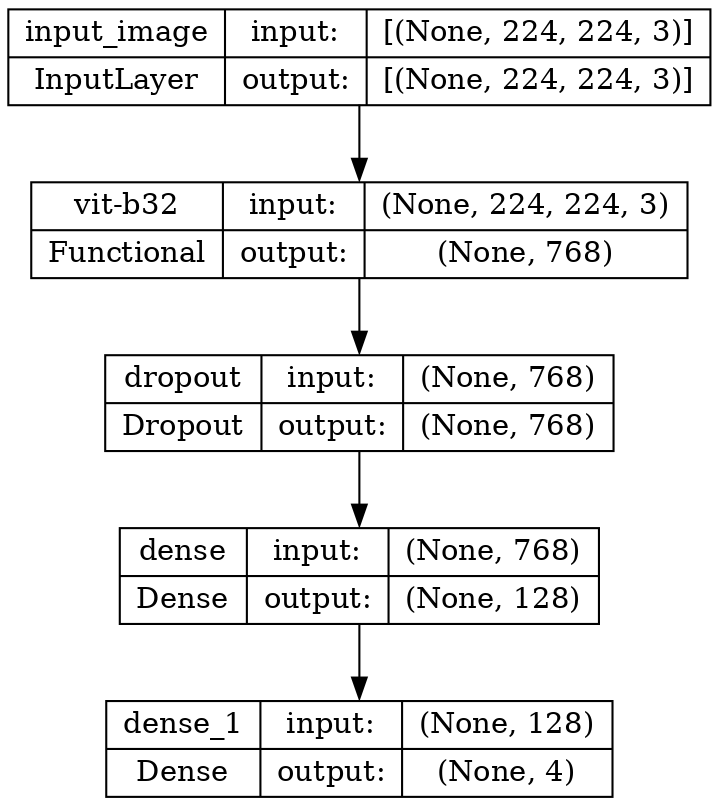

In [24]:
# Plot model architecture
plot_model(
    model_vit_b32, 
    dpi=150,
    show_shapes=True,
    to_file="model_architecture.png",
)

**Compile model**

In [25]:

#Compile the model
model_vit_b32.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [26]:

learning_rate = 1e-3
weight_decay = 1e-7
label_smoothing = 0.1



model_vit_b32.compile(
            optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay = weight_decay),
            loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = label_smoothing),
            metrics = ["accuracy"]
        )


**Training model**

In [27]:

# Define Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True,
    verbose=1)

# Define Reduce Learning Rate callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    factor=0.1,
    verbose=1)

# Define list of callbacks 
callbacks_list = [early_stopping_callback, reduce_lr_callback]


In [28]:

model_history = model_vit_b32.fit(train_dataset, epochs=15, validation_data=valid_dataset, callbacks=callbacks_list)


Epoch 1/15
478/478 [==============================] - 30s 28ms/step - loss: 0.8534 - accuracy: 0.7286 - val_loss: 0.6656 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 2/15
478/478 [==============================] - 11s 23ms/step - loss: 0.6972 - accuracy: 0.8253 - val_loss: 0.6489 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 3/15
478/478 [==============================] - 11s 23ms/step - loss: 0.6544 - accuracy: 0.8546 - val_loss: 0.7169 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/15
478/478 [==============================] - 11s 24ms/step - loss: 0.6290 - accuracy: 0.8682 - val_loss: 0.6064 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 5/15
478/478 [==============================] - 11s 24ms/step - loss: 0.6047 - accuracy: 0.8849 - val_loss: 0.5926 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 6/15
478/478 [==============================] - 11s 24ms/step - loss: 0.5912 - accuracy: 0.8860 - val_loss: 0.6594 - val_accuracy: 0.8482 - lr: 0.0010
Epoch 7/15
478/478 [==============================] - ETA:

In [29]:

# Evaluating model on validation set
val_loss, val_acc = model_vit_b32.evaluate(valid_dataset)


84/84 [==============================] - 2s 20ms/step - loss: 0.5394 - accuracy: 0.9137


In [34]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in valid_dataset], axis=0)

# Convert one-hot encoded labels to integer labels
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Get predictions
y_pred_probs = model_vit_b32.predict(valid_dataset)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Ensure correct number of classes
num_classes = len(np.unique(y_true))
print(f"Detected {num_classes} unique classes.")

# Define class names (ensure these are correct)
class_labels = ['pituitary', 'notumor', 'meningioma', 'glioma']

if num_classes != len(class_labels):
    raise ValueError(f"Mismatch: Model detected {num_classes} classes, but {len(class_labels)} labels were provided.")

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, labels=np.arange(num_classes))
print(report)


84/84 [==============================] - 2s 19ms/step
Detected 4 unique classes.
              precision    recall  f1-score   support

   pituitary       0.93      0.84      0.88        77
     notumor       0.88      0.85      0.86        78
  meningioma       0.95      0.97      0.96        98
      glioma       0.89      0.98      0.93        83

    accuracy                           0.91       336
   macro avg       0.91      0.91      0.91       336
weighted avg       0.91      0.91      0.91       336



84/84 [==============================] - 2s 19ms/step


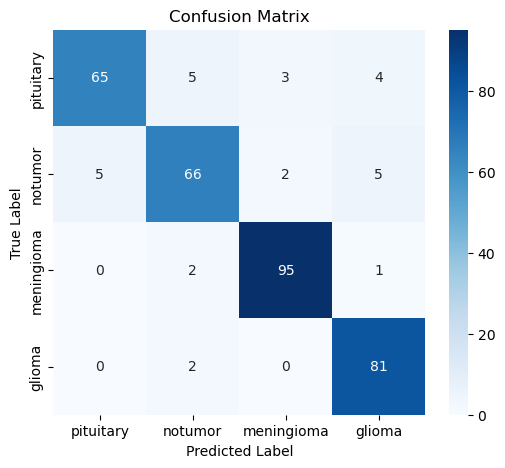

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in valid_dataset], axis=0)

# Convert one-hot encoded labels to integer labels
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Get predictions
y_pred_probs = model_vit_b32.predict(valid_dataset)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Define class names (ensure these match your dataset)
class_labels = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

84/84 [==============================] - 2s 19ms/step


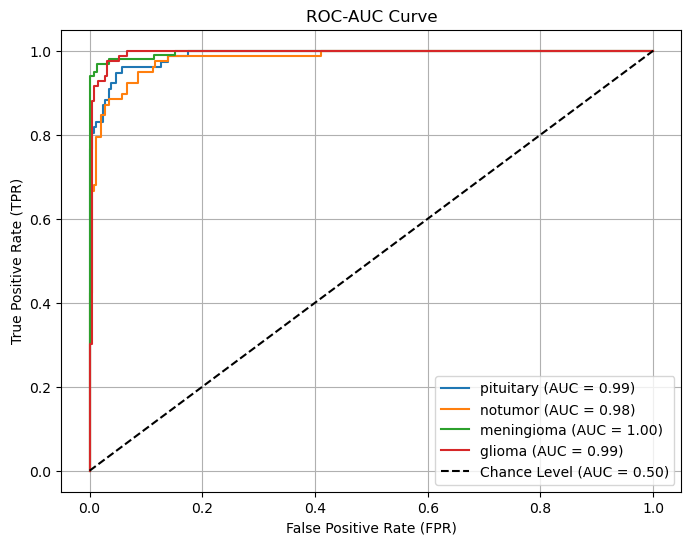

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in valid_dataset], axis=0)

# If labels are one-hot encoded, keep them as is; otherwise, binarize them
if y_true.ndim == 1:
    y_true = label_binarize(y_true, classes=[0, 1, 2, 3])  # Adjust based on your dataset

# Get predicted probabilities
y_pred_probs = model_vit_b32.predict(valid_dataset)

# Define class names
class_labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
n_classes = len(class_labels)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level (AUC = 0.50)")

# Formatting the plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid()
plt.show()